# KENV

<a href=mailto:fuodorov1998@gmail.com>V. Fedorov</a>, <a href=mailto:nikdanila@bk.ru>D. Nikiforov</a>, <a href=http://www.inp.nsk.su/~petrenko/>A. Petrenko</a>, (Novosibirsk, 2019)

## Manual

In [1]:
import kenv as kv

Сan call for help:

In [2]:
#help(kv)

## Simulation

To obtain an envelope, you need to create a beam and an accelerator. Then load the simulation of this beam in this accelerator and apply tracking.

In [3]:
beam = kv.Beam(energy=2,
               current=2e3,
               radius=50e-3,
               x = 30e-3,
               y = 0,
               rp=55.0e-3,
               normalized_emittance=1000e-6)

Can print:

In [4]:
print(beam)

Beam parameters:
	Current	2000 A
	Energy	2.000 MeV
	Total momentum	2.458 MeV/c
	Rel. factor	4.914
	Radius x	50.0 mm
	Radius y	50.0 mm
	Radius x prime	55.0 mrad
	Radius y prime	55.0 mrad
	Horizontal centroid position	30.0 mm
	Vertical centroid position	0.0 mm
	Horizontal centroid angle	0.0 mrad
	Vertical centroid angle	0.0 mrad
	Larmor angle	0.0 rad
	Normalized emittance x	1000.0 mm*mrad
	Normalized emittance y	1000.0 mm*mrad



In [5]:
accelerator = kv.Accelerator(0.7, 15, 0.001)

In [6]:
Solenoids = [ 
    [ 0.95,       0.001,    'Bz.dat', 'Sol. 1' ],
    [ 2.1,        0.03,     'Bz.dat', 'Sol. 2' ],
    [ 2.9077,     0.001,    'Bz.dat', 'Sol. 3' ],
    [ 4.0024,     0.03,     'Bz.dat', 'Sol. 4' ],
    [ 5.642,      0.03,     'Bz.dat', 'Sol. 5' ],
    [ 6.760,      0.001,    'Bz.dat', 'Sol. 6' ],
]

In [7]:
Accels = [
    [ 7.456,       -0.9,     'Ez.dat',  'Cavity 3'],
    [ 8.838,       -0.9,     'Ez.dat',  'Cavity 4'],
    [ 10.220,      -0.9,     'Ez.dat',  'Cavity 5'],
    [ 11.602,      -0.9,     'Ez.dat',  'Cavity 6'],
    [ 12.984,      -0.9,     'Ez.dat',  'Cavity 7'],
    [ 14.366,      -0.9,     'Ez.dat',  'Cavity 8'],    
]

In [8]:
for   z0, B0, filename, name in Solenoids:
    accelerator.Bz_beamline[name] = kv.Element(z0, B0, filename, name, x=0.002, xp=0.005, yp=0.005)
for   z0, E0, filename, name in Accels:
    accelerator.Ez_beamline[name] = kv.Element(z0, E0, filename, name)

In [9]:
accelerator.compile()

In [10]:
simulation = kv.Simulation(beam, accelerator)

In [11]:
simulation.track()

## Graphic with holoviews

### matplotlib

In [12]:
import holoviews as hv
hv.extension('matplotlib')

%opts Layout [tight=True]
%output size=250 backend='matplotlib' fig='png'

%opts Area Curve [aspect=3 show_grid=True]
%opts Area  (alpha=0.25)
%opts Curve (alpha=0.5)
%opts Area.Beam [aspect=3 show_grid=True] (color='red' alpha=0.3)

import warnings
warnings.filterwarnings('ignore')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [13]:
dim_z  = hv.Dimension('z',  unit='m', range=(accelerator.start, accelerator.stop))
dim_z_zoom = hv.Dimension('z_zoom',  unit='m', range=(7, 8.0))
dim_Bz = hv.Dimension('Bz', unit='T', label='Bz')
dim_Ez = hv.Dimension('Ez', unit='MV/m', label='Ez')
dim_dEzdz = hv.Dimension('dEzdz', unit='$\mathrm{MV/m^2}$', label='$dE_z/dz$', range=(-5,+5))
dim_dEzdz_zoom = hv.Dimension('dEzdz_zoom', unit='$\mathrm{MV/m^2}$', label='$dE_z/dz$_zoom', range=(-8,+8))
dim_dBzdz = hv.Dimension('dBzdz', unit='T/m', label='$dB_z/dz$', range=(-0.22,+0.22))

dim_x = hv.Dimension('x', label="Coordinate", unit='mm', range=(-40,40))
dim_y = hv.Dimension('y', label="Coordinate", unit='mm', range=(-40,40))
dim_r = dim_x
dim_phase = hv.Dimension('phase', label="Larmor phase $\Psi$", unit='rad')

In [14]:
z_Ez = hv.Area((accelerator.parameter,accelerator.Ez(accelerator.parameter)), kdims=dim_z, vdims=dim_Ez)
z_dEzdz = hv.Area((accelerator.parameter,-accelerator.dEzdz(accelerator.parameter)), kdims=dim_z, vdims=dim_dEzdz)
z_dEzdz_zoom = hv.Area((accelerator.parameter,-accelerator.dEzdz(accelerator.parameter)), kdims=dim_z_zoom, vdims=dim_dEzdz_zoom)
z_Bz = hv.Area((accelerator.parameter,accelerator.Bz(accelerator.parameter)), kdims=dim_z, vdims=dim_Bz)
z_dBzdz = hv.Area((accelerator.parameter,-accelerator.dBzdz(accelerator.parameter)), kdims=dim_z, vdims=dim_dBzdz)

z_r = hv.Area(((accelerator.parameter,simulation.envelope_x(accelerator.parameter)*1e3)), kdims=[dim_z], vdims=[dim_r], group='Beam')
z_x_centroid = hv.Curve(((accelerator.parameter,simulation.centroid_x(accelerator.parameter)*1e3)), kdims=[dim_z], vdims=[dim_x], group='Beam', label='x')
z_y_centroid = hv.Curve(((accelerator.parameter,simulation.centroid_y(accelerator.parameter)*1e3)), kdims=[dim_z], vdims=[dim_y], group='Beam', label='y')

z_larmor_phase = hv.Curve(((accelerator.parameter,simulation.larmor_angle(accelerator.parameter))), kdims=[dim_z], vdims=[dim_phase])


:Layout
   .Beam.I  :Overlay
      .Beam.X :Curve   [z]   (x)
      .Beam.Y :Curve   [z]   (y)
   .Curve.I :Curve   [z]   (phase)
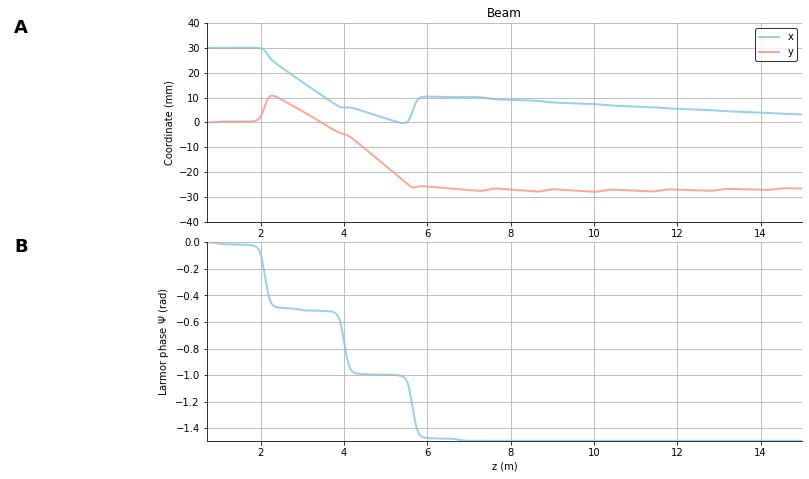

In [15]:
(z_x_centroid*z_y_centroid+z_larmor_phase).cols(1)

:Layout
   .Area.I   :Area   [z]   (Bz)
   .Area.II  :Area   [z]   (Ez)
   .Area.III :Area   [z]   (dEzdz)
   .Area.IV  :Area   [z_zoom]   (dEzdz_zoom)
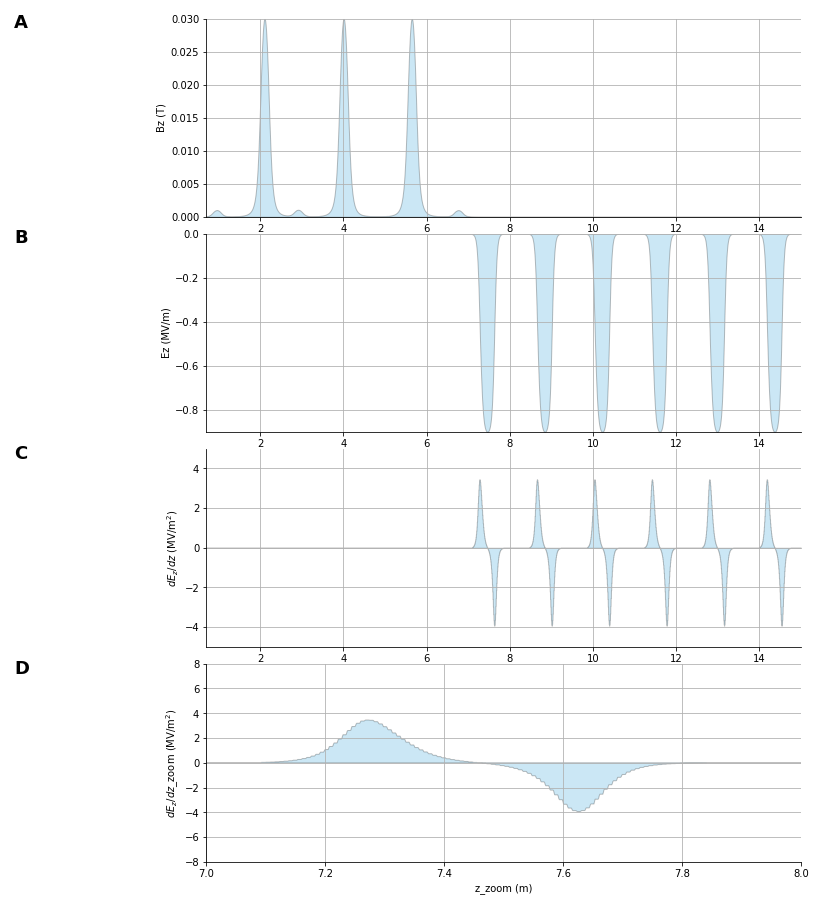

In [16]:
(z_Bz + z_Ez + z_dEzdz + z_dEzdz_zoom).cols(1)

## Astra vs KENV

In [17]:
import pandas as pd

:Layout
   .Overlay.I   :Overlay
      .Astra.Astra.I  :Curve   [z,x]   (id1,id2,y,id4,id5,id6,id7)
      .Beam.X         :Curve   [z]   (x)
      .Astra.Astra.II :Curve   [z,y]   (id1,id2,x,id4,id5,id6,id7)
      .Beam.Y         :Curve   [z]   (y)
   .Overlay.II  :Overlay
      .Curve.I     :Curve   [z]   (phase)
      .Astra.Astra :Curve   [z,phase]   (id)
   .Overlay.III :Overlay
      .Area.I      :Area   [z]   (dBzdz)
      .Astra.Astra :Curve   [z,dBzdz]   (id)
   .Overlay.IV  :Overlay
      .Area.I      :Area   [z]   (dEzdz)
      .Astra.Astra :Curve   [z,dEzdz]   (id)
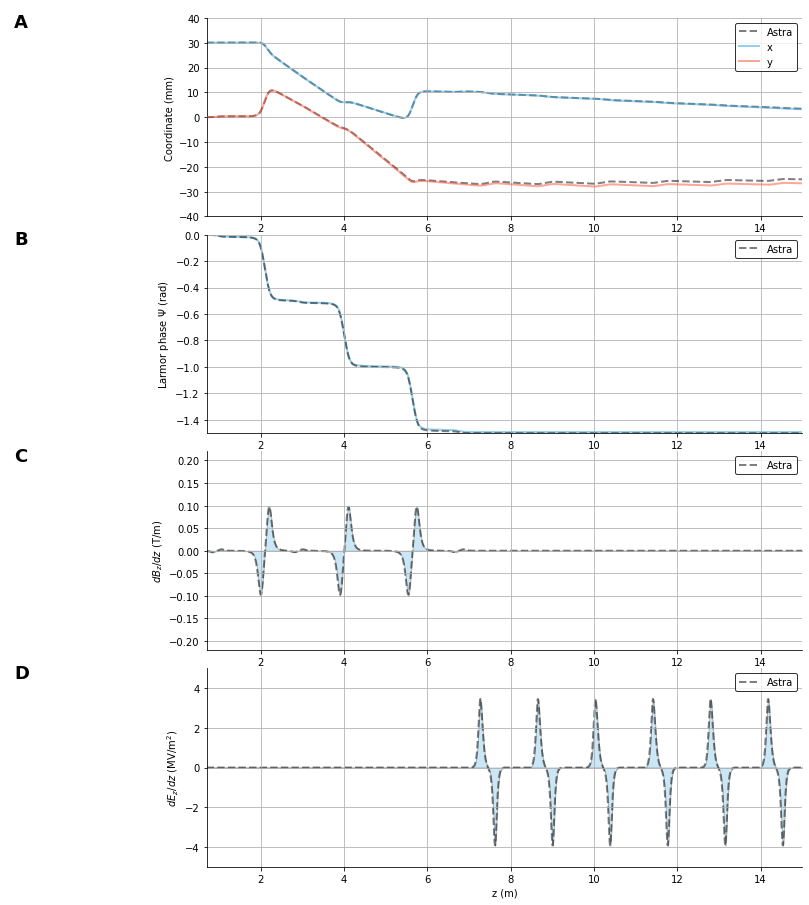

In [18]:
%opts Curve.Astra (linestyle='--' color='black')
track = "input/0B_track_centroid/track_centroid.track.001"# Astra output file

cols = ['id1', 'id2', 'z', 'x', 'y', 'id4', 'id5', 'id6', 'id7']
df = pd.read_csv(track, header=None, delim_whitespace=True, names=cols, dtype='float32')

larmor = "input/0B_track_centroid/larmor_angle.dat"
cols_larmor = ['z', 'phase','id']
df_larmor = pd.read_csv(larmor, header=None, delim_whitespace=True, names=cols_larmor, dtype='float32')

field_dEz = "input/0B_track_centroid/dEz.dat"
cols_dEz = ['z', 'dEzdz', 'id']
df_dEz = pd.read_csv(field_dEz, header=None, delim_whitespace=True, names=cols_dEz, dtype='float32')

field_dBz = "input/0B_track_centroid/dBz.dat"
cols_dBz = ['z', 'dBzdz', 'id']
df_dBz = pd.read_csv(field_dBz, header=None, delim_whitespace=True, names=cols_dBz, dtype='float32')

z_x_astra = hv.Curve(df, kdims=[dim_z,dim_x], label='Astra', group = 'Astra')
z_y_astra = hv.Curve(df, kdims=[dim_z,dim_y], label='Astra', group = 'Astra')
z_larmor_astra = hv.Curve(df_larmor, kdims=[dim_z,dim_phase], label='Astra', group = 'Astra')
z_dEzdz_astra = hv.Curve(df_dEz, kdims=[dim_z,dim_dEzdz], label='Astra', group = 'Astra')
z_dBzdz_astra = hv.Curve(df_dBz, kdims=[dim_z,dim_dBzdz], label='Astra', group = 'Astra')


(z_x_astra*z_x_centroid*z_y_astra*z_y_centroid+z_larmor_phase*z_larmor_astra+z_dBzdz*z_dBzdz_astra+z_dEzdz*z_dEzdz_astra).cols(1)

## Difference 

In [19]:

cols = ['id1', 'id2', 'z', 'x', 'y', 'id4', 'id5', 'id6', 'id7']
df = pd.read_csv(track, header=None, delim_whitespace=True, names=cols, dtype='float32')

import numpy as np
x_astra_array = df['x']
y_astra_array = df['y']
z_array = df['z']

In [20]:
x_kenv_array = np.interp(z_array, accelerator.parameter, simulation.centroid_x(accelerator.parameter)*1e3)
y_kenv_array = np.interp(z_array, accelerator.parameter, simulation.centroid_y(accelerator.parameter)*1e3)

In [21]:
delta_x = -x_kenv_array+x_astra_array
delta_y = -y_kenv_array+y_astra_array

:Layout
   .Overlay.I :Overlay
      .Curve.Reverse_over_delta_x :Curve   [z]   (x)
      .Curve.Reverse_over_delta_y :Curve   [z]   (y)
   .Area.I    :Area   [z]   (dBzdz)
   .Area.II   :Area   [z]   (dEzdz)
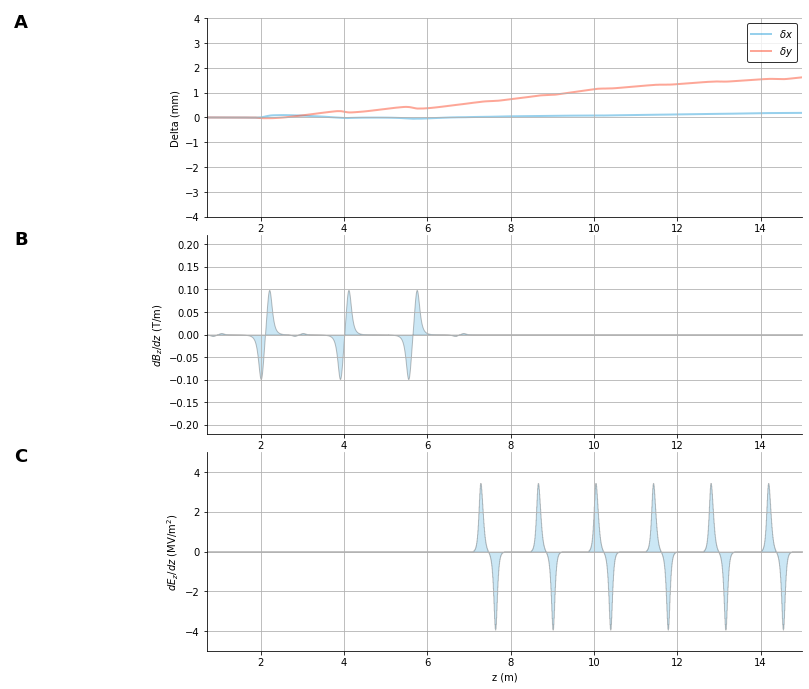

In [22]:
dim_x = hv.Dimension('x', label="Delta", unit='mm', range=(-4,4))
dim_y = hv.Dimension('y', label="Delta", unit='mm', range=(-4,4))


(hv.Curve(((z_array, delta_x)), kdims=[dim_z], vdims=[dim_x], label='$\delta x$')\
*hv.Curve(((z_array, delta_y)), kdims=[dim_z], vdims=[dim_y], label='$\delta y$')+z_dBzdz+z_dEzdz).cols(1)